In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 'n_iter', 
                         'train_accuracy', 'val_accuracy']] = cv_results[['param_C', 'mean_fit_time', 'mean_train_n_iter', 
                                                                          'mean_train_accuracy', 'mean_test_accuracy']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

In [87]:
lin_X, lin_y = generate_linearly_separable_overlap_data()
nonlin_X, nonlin_y = generate_nonlinearly_separable_data()

## Hinge loss

### Primal formulation

In [5]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane, plot_model_loss

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [6]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


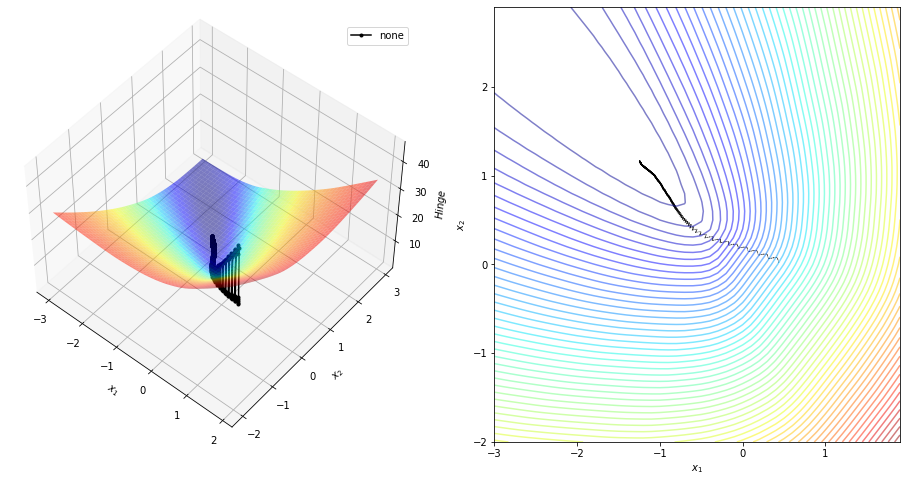

In [88]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
hinge_loss_opt = plot_trajectory_optimization(hinge_loss, grid.best_estimator_.optimizer, color='k', label='none')

In [89]:
none_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_hinge_cv_results.insert(2, 'momentum', 'none')
none_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
none_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.710145    2743        0.947462      0.939846   
       10  none      0.518066    1770        0.954962      0.944821   
       100 none      0.317060     813        0.954962      0.944821   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              40        20  
       10  none              19        11  
       100 none              14         7

Fitting 3 folds for each of 3 candidates, totalling 9 fits


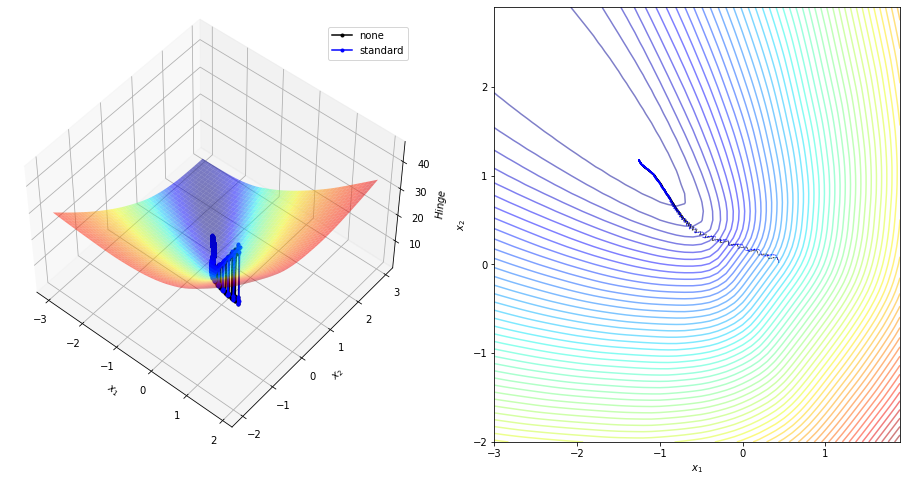

In [90]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='standard', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='b', label='standard')
hinge_loss_opt

In [91]:
standard_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_hinge_cv_results.insert(2, 'momentum', 'standard')
standard_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
standard_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   standard  0.520384    2101        0.947462      0.939846   
       10  standard  0.357653    1324        0.954962      0.944821   
       100 standard  0.184168     528        0.954962      0.944821   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   standard          37        19  
       10  standard          17        10  
       100 standard          13         8

Fitting 3 folds for each of 3 candidates, totalling 9 fits


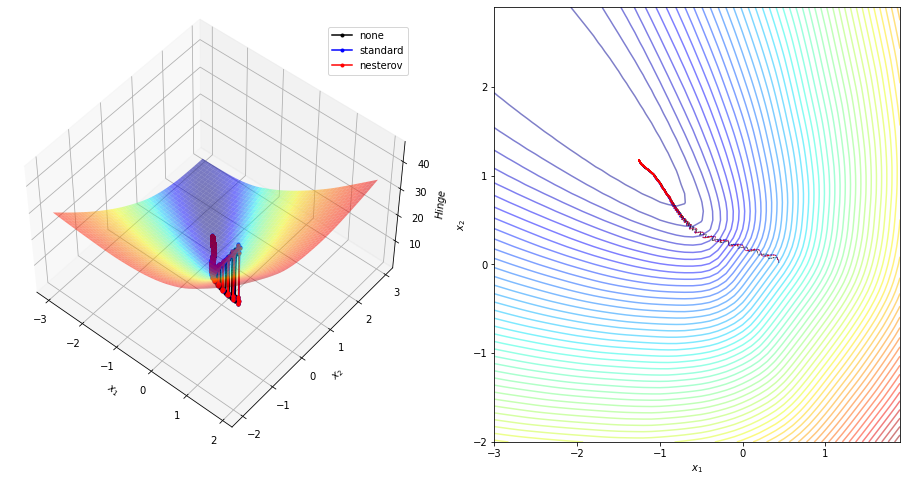

In [92]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='nesterov', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='r', label='nesterov')
hinge_loss_opt.savefig('./tex/img/svc_hinge_loss.png')
hinge_loss_opt

In [93]:
nesterov_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_hinge_cv_results.insert(2, 'momentum', 'nesterov')
nesterov_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
nesterov_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   nesterov  0.516617    2099        0.947462      0.939846   
       10  nesterov  0.362264    1256        0.954962      0.944821   
       100 nesterov  0.144800     449        0.954962      0.944821   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   nesterov          37        19  
       10  nesterov          17        10  
       100 nesterov          14         7

In [94]:
custom_primal_svc_hinge_cv_results = none_primal_svc_hinge_cv_results.append(standard_primal_svc_hinge_cv_results).append(nesterov_primal_svc_hinge_cv_results)
custom_primal_svc_hinge_cv_results.sort_values('C', inplace=True)
custom_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.710145    2743        0.947462      0.939846   
           standard  0.520384    2101        0.947462      0.939846   
           nesterov  0.516617    2099        0.947462      0.939846   
       10  none      0.518066    1770        0.954962      0.944821   
           standard  0.357653    1324        0.954962      0.944821   
           nesterov  0.362264    1256        0.954962      0.944821   
       100 none      0.317060     813        0.954962      0.944821   
           standard  0.184168     528        0.954962      0.944821   
           nesterov  0.144800     449        0.954962      0.944821   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              40        20  
           standard          37        19  
           nesterov          37        19  
       10  none              19        11  
           standard          17        10  
           nesterov          17        10  
       100 none              14         7  
           standard          13         8  
           nesterov          14         7

In [95]:
grid = GridSearchCV(SkLinearSVC(loss='hinge', dual=False, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [96]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
liblinear 1   -         0.001606     386        0.952456      0.939846   
          10  -         0.001603     980        0.962462      0.949872   
          100 -         0.001761    1000        0.964968      0.954998   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
liblinear 1   -                 17         9  
          10  -                 12         6  
          100 -                 10         5

In [97]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', 
                                     caption='SVC Primal formulation results with Hinge loss', 
                                     label='primal_svc_hinge_cv_results', position='H')
primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
sgd       1   none      0.710145    2743        0.947462      0.939846   
              standard  0.520384    2101        0.947462      0.939846   
              nesterov  0.516617    2099        0.947462      0.939846   
          10  none      0.518066    1770        0.954962      0.944821   
              standard  0.357653    1324        0.954962      0.944821   
              nesterov  0.362264    1256        0.954962      0.944821   
          100 none      0.317060     813        0.954962      0.944821   
              standard  0.184168     528        0.954962      0.944821   
              nesterov  0.144800     449        0.954962      0.944821   
liblinear 1   -         0.001606     386        0.952456      0.939846   
          10  -         0.001603     980        0.962462      0.949872   
          100 -         0.001761    1000        0.964968      0.954998   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
sgd       1   none              40        20  
              standard          37        19  
              nesterov          37        19  
          10  none              19        11  
              standard          17        10  
              nesterov          17        10  
          100 none              14         7  
              standard          13         8  
              nesterov          14         7  
liblinear 1   -                 17         9  
          10  -                 12         6  
          100 -                 10         5

### Dual formulations

In [120]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [121]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [122]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


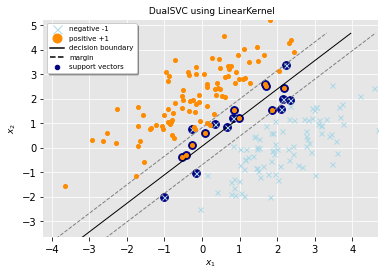

In [124]:
grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svc_hyperplane.png')

In [125]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
cvxopt 1    0.032567      10        0.967493      0.969998          15   
       10   0.020921      10        0.967493      0.969998          14   
       100  0.043281      10        0.967493      0.964948          24   
smo    1    0.054521      41        0.967493      0.969998          15   
       10   0.178687     216        0.967493      0.964948          12   
       100  0.463555    1039        0.967493      0.964948          11   

            val_n_sv  
solver C              
cvxopt 1          15  
       10         14  
       100        24  
smo    1          15  
       10         12  
       100        11

In [126]:
grid = GridSearchCV(SklSVC(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM]

In [127]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
libsvm 1    0.001915      58        0.969981      0.964948          15   
       10   0.003209     728        0.969981      0.964948          12   
       100  0.004323    4114        0.967493      0.964948          11   

            val_n_sv  
solver C              
libsvm 1          15  
       10         12  
       100        11

In [128]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', 
                                    caption='Linear SVC Wolfe Dual formulation results with Hinge loss', 
                                    label='linear_dual_svc_cv_results', position='H')
linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
smo    1    0.054521      41        0.967493      0.969998          15   
       10   0.178687     216        0.967493      0.964948          12   
       100  0.463555    1039        0.967493      0.964948          11   
libsvm 1    0.001915      58        0.969981      0.964948          15   
       10   0.003209     728        0.969981      0.964948          12   
       100  0.004323    4114        0.967493      0.964948          11   
cvxopt 1    0.032567      10        0.967493      0.969998          15   
       10   0.020921      10        0.967493      0.969998          14   
       100  0.043281      10        0.967493      0.964948          24   

            val_n_sv  
solver C              
smo    1          15  
       10         12  
       100        11  
libsvm 1          15  
       10         12  
       100        11  
cvxopt 1          15  
       10         14  
       100        24

##### Nonlinear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


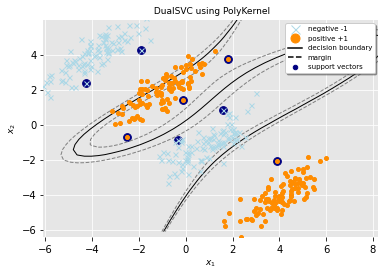

In [156]:
grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svc_hyperplane.png')

In [157]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.085239      10        0.815039      0.705981          32   
              10   0.074714      10        0.926131      0.743650          10   
              100  0.066410      10        0.957426      0.828302           9   
smo    poly   1    0.300656      94        0.816287      0.708488          32   
              10   0.304991     108        0.926131      0.743650          10   
              100  0.265495     172        0.957426      0.828302           8   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          32  
              10         10  
              100         9  
smo    poly   1          32  
              10         10  
              100         8

Fitting 3 folds for each of 6 candidates, totalling 18 fits


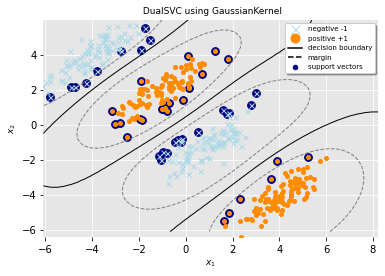

In [158]:
grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svc_hyperplane.png')

In [159]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt rbf    1    0.096586      10        0.998747           1.0          44   
              10   0.082683      10        1.000000           1.0          15   
              100  0.073029      10        1.000000           1.0          14   
smo    rbf    1    0.253971      50        0.998747           1.0          43   
              10   0.275428      93        1.000000           1.0          14   
              100  0.220114      81        1.000000           1.0          11   

                   val_n_sv  
solver kernel C              
cvxopt rbf    1          44  
              10         15  
              100        14  
smo    rbf    1          43  
              10         14  
              100        11

In [160]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.085239      10        0.815039      0.705981          32   
              10   0.074714      10        0.926131      0.743650          10   
              100  0.066410      10        0.957426      0.828302           9   
       rbf    1    0.096586      10        0.998747      1.000000          44   
              10   0.082683      10        1.000000      1.000000          15   
              100  0.073029      10        1.000000      1.000000          14   
smo    poly   1    0.300656      94        0.816287      0.708488          32   
              10   0.304991     108        0.926131      0.743650          10   
              100  0.265495     172        0.957426      0.828302           8   
       rbf    1    0.253971      50        0.998747      1.000000          43   
              10   0.275428      93        1.000000      1.000000          14   
              100  0.220114      81        1.000000      1.000000          11   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          32  
              10         10  
              100         9  
       rbf    1          44  
              10         15  
              100        14  
smo    poly   1          32  
              10         10  
              100         8  
       rbf    1          43  
              10         14  
              100        11

In [161]:
grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LibSVM]

In [162]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
libsvm poly   1    0.003757     270        0.998747      0.992481          32   
              10   0.003405     319        1.000000      0.992481          10   
              100  0.003105     274        1.000000      0.992481           8   
       rbf    1    0.003656      99        1.000000      1.000000          44   
              10   0.004566     149        1.000000      1.000000          14   
              100  0.003053     205        1.000000      1.000000          11   

                   val_n_sv  
solver kernel C              
libsvm poly   1          32  
              10         10  
              100         8  
       rbf    1          44  
              10         14  
              100        11

In [163]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', 
                                       caption='Nonlinear SVC Wolfe Dual formulation results with Hinge loss', 
                                       label='nonlinear_dual_svc_cv_results', position='H')
nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
smo    poly   1    0.300656      94        0.816287      0.708488          32   
              10   0.304991     108        0.926131      0.743650          10   
              100  0.265495     172        0.957426      0.828302           8   
       rbf    1    0.253971      50        0.998747      1.000000          43   
              10   0.275428      93        1.000000      1.000000          14   
              100  0.220114      81        1.000000      1.000000          11   
libsvm poly   1    0.003757     270        0.998747      0.992481          32   
              10   0.003405     319        1.000000      0.992481          10   
              100  0.003105     274        1.000000      0.992481           8   
       rbf    1    0.003656      99        1.000000      1.000000          44   
              10   0.004566     149        1.000000      1.000000          14   
              100  0.003053     205        1.000000      1.000000          11   
cvxopt poly   1    0.085239      10        0.815039      0.705981          32   
              10   0.074714      10        0.926131      0.743650          10   
              100  0.066410      10        0.957426      0.828302           9   
       rbf    1    0.096586      10        0.998747      1.000000          44   
              10   0.082683      10        1.000000      1.000000          15   
              100  0.073029      10        1.000000      1.000000          14   

                   val_n_sv  
solver kernel C              
smo    poly   1          32  
              10         10  
              100         8  
       rbf    1          43  
              10         14  
              100        11  
libsvm poly   1          32  
              10         10  
              100         8  
       rbf    1          44  
              10         14  
              100        11  
cvxopt poly   1          32  
              10         10  
              100         9  
       rbf    1          44  
              10         15  
              100        14

#### Lagrangian Dual

##### Linear

In [139]:
grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [140]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], ascending=False, inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', 
                                               caption='Linear SVC Lagrangian Dual formulation results with Hinge loss', 
                                               label='linear_lagrangian_dual_svc_cv_results', position='H')
linear_lagrangian_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  val_n_sv
dual C                                                                        
qp   1    0.009340       1        0.977518      0.980024         130       130
     10   0.005536       1        0.977518      0.980024         130       130
     100  0.006986       1        0.977518      0.980024         130       130
bcqp 1    0.006575       1        0.964987      0.980024         129       129
     10   0.005960       1        0.964987      0.980024         129       129
     100  0.004786       1        0.964987      0.980024         129       129

##### Nonlinear

In [142]:
grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [143]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', 
                                                  caption='Nonlinear SVC Lagrangian Dual formulation results with Hinge loss', 
                                                  label='nonlinear_lagrangian_dual_svc_cv_results', position='H')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
dual kernel C                                                                 
qp   poly   1    0.635557     126        0.774971      0.521266         205   
            10   0.579004     121        0.782462      0.533797         205   
            100  0.612130     121        0.782462      0.533797         205   
     rbf    1    1.728111     269        0.758741      0.501253         136   
            10   0.553077      82        0.750002      0.501253         109   
            100  1.160888     359        0.831151      0.578947         149   
bcqp poly   1    1.149153     347        0.784959      0.543785         206   
            10   0.986511     347        0.784959      0.543785         206   
            100  0.718925     347        0.784959      0.543785         206   
     rbf    1    0.022847       1        0.998747      0.992519         249   
            10   0.020183       1        0.998747      0.992519         249   
            100  0.020089       1        0.998747      0.992519         249   

                 val_n_sv  
dual kernel C              
qp   poly   1         205  
            10        205  
            100       205  
     rbf    1         136  
            10        109  
            100       149  
bcqp poly   1         206  
            10        206  
            100       206  
     rbf    1         249  
            10        249  
            100       249

## Squared Hinge loss

### Primal formulation

In [37]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [38]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


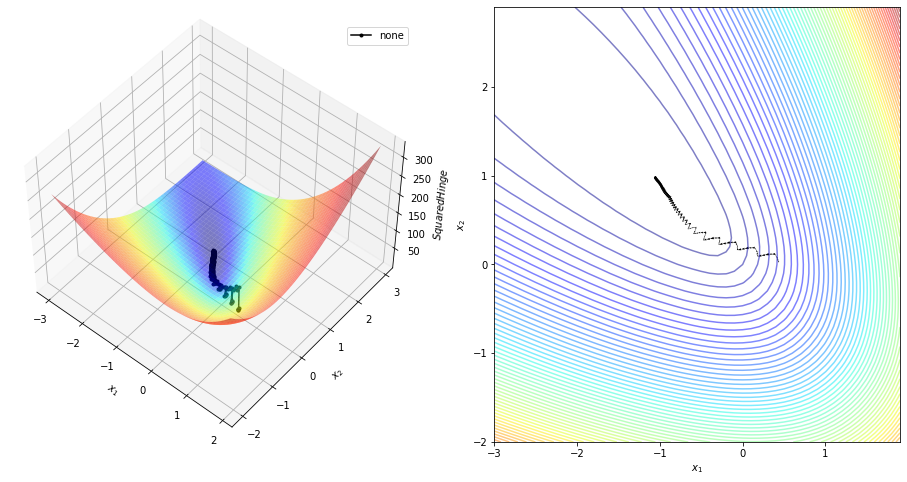

In [98]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss, grid.best_estimator_.optimizer, 
                                                      color='k', label='none')

In [99]:
none_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_squared_hinge_cv_results.insert(2, 'momentum', 'none')
none_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
none_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.313461    1273        0.944956      0.939846   
       10  none      0.117412     384        0.952456      0.944821   
       100 none      0.038147      78        0.952456      0.944821   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              40        20  
       10  none              26        13  
       100 none              18        10

Fitting 3 folds for each of 3 candidates, totalling 9 fits


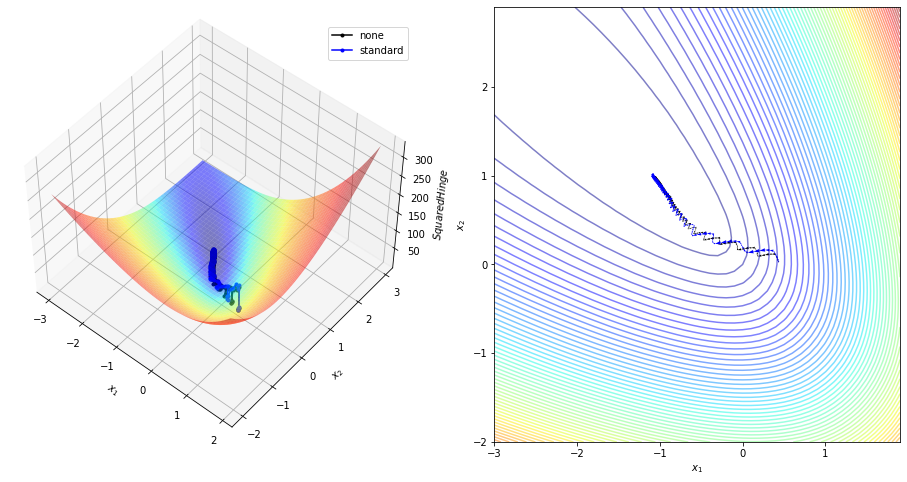

In [100]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='standard', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='b', label='standard')
squared_hinge_loss_opt

In [101]:
standard_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_squared_hinge_cv_results.insert(2, 'momentum', 'standard')
standard_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
standard_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   standard  0.253786     930        0.947462      0.939846   
       10  standard  0.078306     239        0.952456      0.944821   
       100 standard  0.051053      83        0.959975      0.944821   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   standard          37        19  
       10  standard          25        13  
       100 standard          15         8

Fitting 3 folds for each of 3 candidates, totalling 9 fits


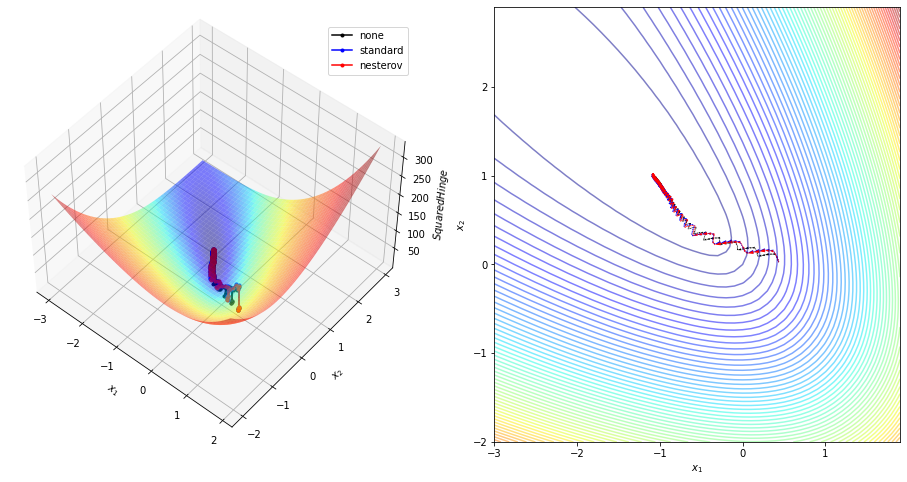

In [102]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='nesterov', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='r', label='nesterov')
squared_hinge_loss_opt.savefig('./tex/img/svc_squared_hinge_loss.png')
squared_hinge_loss_opt

In [103]:
nesterov_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_squared_hinge_cv_results.insert(2, 'momentum', 'nesterov')
nesterov_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
nesterov_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   nesterov  0.245869     934        0.947462      0.939846   
       10  nesterov  0.075893     244        0.952456      0.944821   
       100 nesterov  0.045448      78        0.957468      0.944821   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   nesterov          37        19  
       10  nesterov          25        13  
       100 nesterov          16         8

In [104]:
custom_primal_svc_squared_hinge_cv_results = none_primal_svc_squared_hinge_cv_results.append(standard_primal_svc_squared_hinge_cv_results).append(nesterov_primal_svc_squared_hinge_cv_results)
custom_primal_svc_squared_hinge_cv_results.sort_values('C', inplace=True)
custom_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
sgd    1   none      0.313461    1273        0.944956      0.939846   
           standard  0.253786     930        0.947462      0.939846   
           nesterov  0.245869     934        0.947462      0.939846   
       10  none      0.117412     384        0.952456      0.944821   
           standard  0.078306     239        0.952456      0.944821   
           nesterov  0.075893     244        0.952456      0.944821   
       100 none      0.038147      78        0.952456      0.944821   
           standard  0.051053      83        0.959975      0.944821   
           nesterov  0.045448      78        0.957468      0.944821   

                     train_n_sv  val_n_sv  
solver C   momentum                        
sgd    1   none              40        20  
           standard          37        19  
           nesterov          37        19  
       10  none              26        13  
           standard          25        13  
           nesterov          25        13  
       100 none              18        10  
           standard          15         8  
           nesterov          16         8

In [105]:
grid = GridSearchCV(SkLinearSVC(loss='squared_hinge', dual=False, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [106]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
liblinear 1   -         0.001865     600        0.964968      0.954847   
          10  -         0.002564    1000        0.962462      0.954847   
          100 -         0.002419    1000        0.959956      0.934946   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
liblinear 1   -                 29        14  
          10  -                 28        14  
          100 -                 27        15

In [107]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_svc_squared_hinge.tex', 
                                             caption='SVC Primal formulation results with Squared Hinge loss', 
                                             label='primal_svc_squared_hinge_cv_results', position='H')
primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
sgd       1   none      0.313461    1273        0.944956      0.939846   
              standard  0.253786     930        0.947462      0.939846   
              nesterov  0.245869     934        0.947462      0.939846   
          10  none      0.117412     384        0.952456      0.944821   
              standard  0.078306     239        0.952456      0.944821   
              nesterov  0.075893     244        0.952456      0.944821   
          100 none      0.038147      78        0.952456      0.944821   
              standard  0.051053      83        0.959975      0.944821   
              nesterov  0.045448      78        0.957468      0.944821   
liblinear 1   -         0.001865     600        0.964968      0.954847   
          10  -         0.002564    1000        0.962462      0.954847   
          100 -         0.002419    1000        0.959956      0.934946   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
sgd       1   none              40        20  
              standard          37        19  
              nesterov          37        19  
          10  none              26        13  
              standard          25        13  
              nesterov          25        13  
          100 none              18        10  
              standard          15         8  
              nesterov          16         8  
liblinear 1   -                 29        14  
          10  -                 28        14  
          100 -                 27        15